# A gentle introduction to Gaussian Process Regression

This notebook is edited from https://github.com/dfm/gp.

We'll start by generating some fake data (from a sinusoidal model) with error bars:

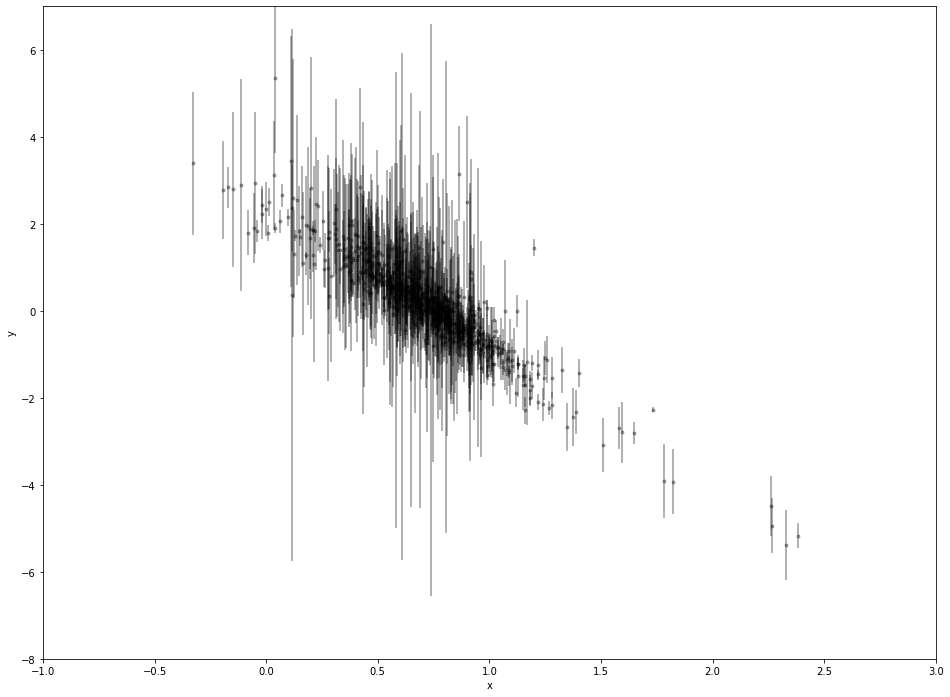

In [81]:
import george
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

datadir = '/Users/nickk124/research/reichart/TRK/TRKrepo_public/testdata/extinctionfits'

datanames = {
    "c1" : "c1c2_data.csv",
    "bh" : "bhc2_data.csv",
    "rv" : "rvc2_data.csv"
}

data_plot_ranges = {
    "c1":((-1, 3), (-8, 7)),
    "bh":((-1, 3), (-1, 8)),
    "rv":((-1, 3), (-1, 8))
}

# dataname = 'rv'
dataname = 'c1'
# dataname = 'bh'

datafilename = os.path.join(datadir, datanames[dataname])

df = pd.read_csv(data)

datadf = pd.read_csv(datafilename, sep=",", names=['x', 'sx', 'y', 'sy', 'w'])

x = datadf['x']
xerr = datadf['sx']
y = datadf['y']
yerr = datadf['sy']
w = datadf['w']


# np.random.seed(1234)
# x = 10 * np.sort(np.random.rand(15))
# yerr = 0.2 * np.ones_like(x)
# y = np.sin(x) + yerr * np.random.randn(len(x))
plt.figure(figsize = (16, 12))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.3, markersize=6, linewidth=2)
plt.xlim(data_plot_ranges[dataname][0])
plt.ylim(data_plot_ranges[dataname][1])
plt.xlabel("x")
plt.ylabel("y");

Now, we'll choose a kernel (covariance) function to model these data, assume a zero mean model, and predict the function values across the full range. The full kernel specification language is documented [here](../../user/kernels/) but here's an example for this dataset:

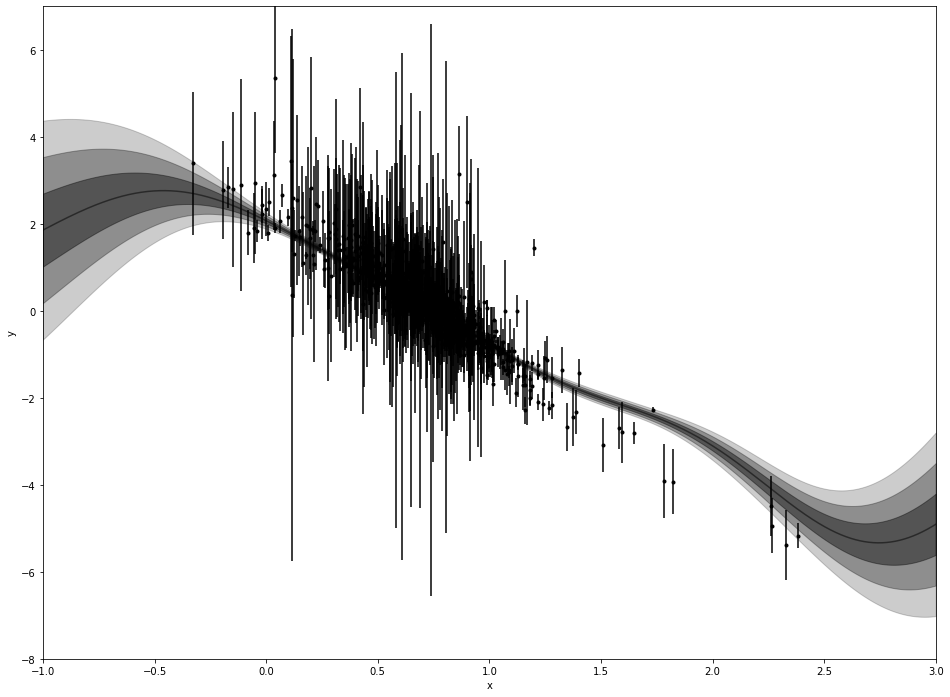

In [82]:
from george import kernels

kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(-1, 3, 1000)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize = (16, 12))
for i in range(1,4):
    plt.fill_between(x_pred, pred - i*np.sqrt(pred_var), pred + i*np.sqrt(pred_var),
                color="k", alpha=0.5 - i*0.1)


plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(data_plot_ranges[dataname][0])
plt.ylim(data_plot_ranges[dataname][1])
plt.xlabel("x")
plt.ylabel("y");

In [83]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -783.13


So we can use this—combined with scipy's [minimize](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function—to fit for the maximum likelihood parameters:

In [84]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: 764.005428216826
 hess_inv: array([[0.44786068, 0.11534689],
       [0.11534689, 0.09173508]])
      jac: array([ 5.62764780e-06, -1.29838554e-06])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([ 2.05418974, -1.1726219 ])

Final ln-likelihood: -764.01


And plot the maximum likelihood model:

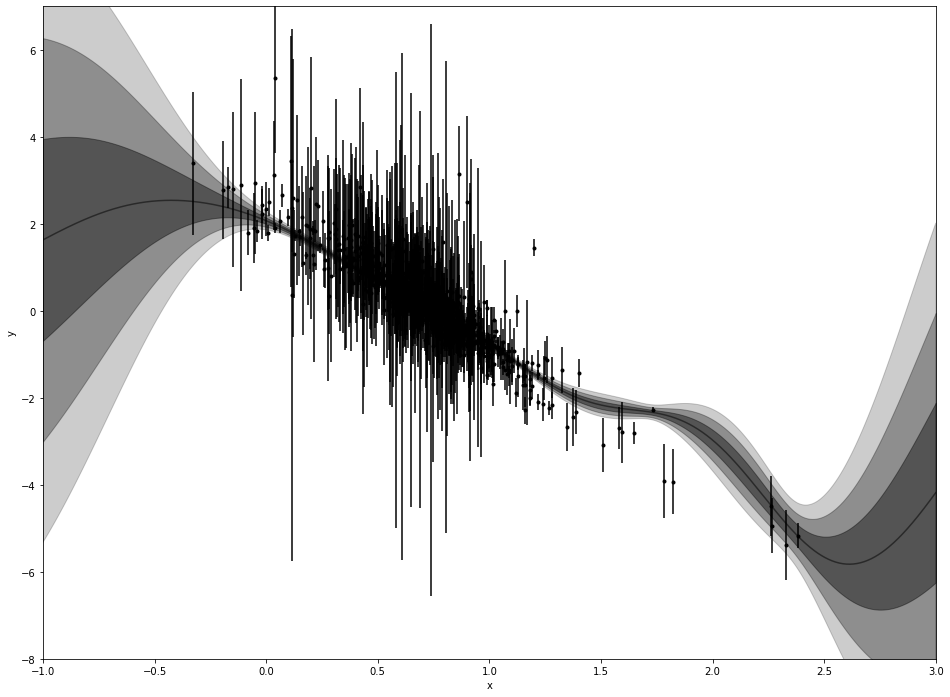

In [85]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize = (16, 12))
for i in range(1,4):
    plt.fill_between(x_pred, pred - i*np.sqrt(pred_var), pred + i*np.sqrt(pred_var),
                color="k", alpha=0.5 - i*0.1)


plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(data_plot_ranges[dataname][0])
plt.ylim(data_plot_ranges[dataname][1])
plt.xlabel("x")
plt.ylabel("y");

And there you have it! Read on to see what else you can do with george or just dive right into your own problem.

Finally, don't forget [Rasmussen & Williams](http://www.gaussianprocess.org/gpml/), the reference for everything Gaussian Process.